In [164]:
#define the simulated radition field
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from filterpy.kalman import KalmanFilter

#lat/long for omaha, NE
#lat = 41.2565
#long = 95.9345

#define a class to hold a radiation field that will be used by other classes
class RadiationField:
  def __init__(self, burst_lat, burst_long, burst_time, altitude):
    self.lat = burst_lat
    self.long = burst_long
    self.time = burst_time
    self.altitude = altitude
  
  def plotField(self):
    raise NotImplementedError("Subclasses must implement plotField method")

  def getDoseRate(self, lat, long, time, altitude):
    raise NotImplementedError("Subclasses must implement calculate_intensity method")
  
class GaussianField(RadiationField):
  def __init__(self, burst_lat, burst_long, burst_time, altitude, sigma, decayConstant):
    super().__init__(burst_lat, burst_long, burst_time, altitude)
    self.sigma = sigma
    self.decayConstant = decayConstant

  def plotFields(self, time=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = np.exp(-((x**2 + y**2)/(2*self.sigma**2)))
    z = np.exp(-time * self.decayConstant)*z
    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('X') 
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')
    ax.set_zlim(0, 1)
    plt.show()

  def plotFields(self, times=[0,1,2]):
    #create a figure with subplots for each time
    fig = plt.figure()
    for t in times:
      ax = fig.add_subplot(1, len(times), t+1, projection='3d')
      x = np.linspace(-10, 10, 100)
      y = np.linspace(-10, 10, 100)
      x, y = np.meshgrid(x, y)
      z = np.exp(-((x**2 + y**2)/(2*self.sigma**2)))
      z = np.exp(-t * self.decayConstant)*z
      ax.plot_surface(x, y, z, cmap='viridis')
      ax.set_xlabel('X') 
      ax.set_ylabel('Y')
      ax.set_zlabel('Intensity')
      ax.set_zlim(0, 1)
      ax.set_title('Time = ' + str(t))
    plt.show()

  def getDoseRate(self, lat, long, time, altitude=0):
    #calculate the distance between the burst and the point
    distance = np.sqrt((lat - self.lat)**2 + (long - self.long)**2 + (altitude - self.altitude)**2)
    #calculate the time since the burst
    timeSinceBurst = time - self.time
    #calculate the intensity
    intensity = np.exp(-distance**2/(2*self.sigma**2))*np.exp(-timeSinceBurst*self.decayConstant)
    return intensity

#define a class to hold a single scattered detector and its related methods
class Detector:
  def __init__(self, id, positionMeasurementNoise=0.2, positionProcessVariance=1e-6, expectedDecayRate=0.1, decayProcessVariance=0.01):
    self.id = id
    self.predictedDoseRateMeasurements = []
    self.predictedDoseRateUncertainties = []
    self.predictionTimes = []
    self.predictedLat = 0
    self.predictedLong = 0

    #initialize the kalman filter for estimating the detector position
    self.positionFilter = KalmanFilter(dim_x=4, dim_z=2)
    self.positionFilter.x = np.array([0, 0, 0, 0]) #initial state (x, y, xdot, ydot)
    self.positionFilter.F = np.array([[1, 0, 1, 0], #state transition matrix
                                      [0, 1, 0, 1],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])
    self.positionFilter.H = np.array([[1, 0, 0, 0], #measurement function
                                      [0, 1, 0, 0]])
    self.positionFilter.R = np.eye(2) * positionMeasurementNoise # Measurement noise - this should be near what is expiemntally measured, estimated to be 200 meters
    self.positionFilter.Q = np.eye(4) * positionProcessVariance  # Process noise - static placement, so this is low

    #initialize the kalman filter for dose rate estimation
    self.doseRateFilter = KalmanFilter(dim_x=2, dim_z=1)
    self.doseRateFilter.x = np.array([0, 1]) #initial state (dose rate and decay rate)
    self.doseRateFilter.F = np.array([[1, 1], [0, 1]]) #state transition matrix
    self.doseRateFilter.H = np.array([[1, 0]]) #measurement function
    self.doseRateFilter.R = np.array([[1e-2]]) #initial measurement noise
    self.doseRateFilter.Q = np.array([[0, 0],[0, decayProcessVariance*expectedDecayRate**2]]) #process noise
  
  def plotDoseRate(self, trueDoseRates):
    #create a figure with subplots for each time
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.errorbar(self.predictionTimes, self.predictedDoseRateMeasurements, yerr=self.predictedDoseRateUncertainties, fmt='o')
    ax.plot(self.predictionTimes, trueDoseRates, 'r')
    ax.set_xlabel('Time') 
    ax.set_ylabel('Dose Rate')
    plt.show()

  def update(self, doseMeasurement, doseSigma, tofs, time):
    #if this is the first measurement, set the initial state to the measurement
    if len(self.predictionTimes) == 0:
      self.positionFilter.x = np.array([0, 0, 0, 0])
      self.doseRateFilter.x = np.array([doseMeasurement, 1])

    self.predictionTimes.append(time)
    #update the dose rate filter
    self.doseRateFilter.R = np.array([[doseSigma]])
    self.doseRateFilter.predict()
    self.doseRateFilter.update(doseMeasurement)
    self.predictedDoseRateMeasurements.append(self.doseRateFilter.x[0])
    self.predictedDoseRateUncertainties.append(np.sqrt(self.doseRateFilter.P[0,0]))

from math import radians, sin, cos, sqrt, atan2
class SimDetector(Detector):
  def __init__(self, lat, long, simRadField, id, positionMeasurementNoise=0.2, positionProcessVariance=1e-6, expectedDecayRate=0.1, decayProcessVariance=0.01, detMeasurementUncertainty=0.2):
    super().__init__(id, positionMeasurementNoise, positionProcessVariance, expectedDecayRate, decayProcessVariance)
    self.trueLat = lat
    self.trueLong = long
    self.simRadField = simRadField
    self.trueDoseRates = []
    self.detMeasurementUncertainty = detMeasurementUncertainty
  
  def getTrueDoseRate(self, time):
    return self.simRadField.getDoseRate(self.trueLat, self.trueLong, time)
  
  def getDoseRateMeasurement(self, time):
    trueDoseRate = self.getTrueDoseRate(time)

    #z_train = z_test + np.random.normal(0, z_test*meas_uncertainty, (n_time_samples, n_detectors)) + minimum_noise*np.random.normal(0, minimum_noise_uncertainty, (n_time_samples, n_detectors))
    #meas_uncertainty = 0.1 # relative uncertainty of 10%
    minimum_noise = 0.2
    minimum_noise_uncertainty = 0.01

    #add noise to the true dose rate
    doseMeasurement = trueDoseRate + np.random.normal(0, trueDoseRate*self.detMeasurementUncertainty ) + minimum_noise*np.random.normal(0, minimum_noise_uncertainty)
    #ensure the measurement is positive
    if doseMeasurement < 0:
      doseMeasurement = 0
    return doseMeasurement
  
  def haversine_distance(self, lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    radius_earth = 6371  # Radius of the Earth in kilometers
    distance = radius_earth * c * 1000  # Convert to meters
    return distance
  
  def getGatewayTimeOfFlights(self, gateways):
    #calculate the time of flight to each gateway in ns, then add noise
    tofs = []
    for gateway in gateways:
      distance = self.haversine_distance(self.trueLat, self.trueLong, gateway.lat, gateway.long)
      tof = distance / 299792458 * 1e9 #nanoseconds
      #add uniform noise to the time of flight, between -50 and 50 ns
      tof += np.random.uniform(-50, 50)
      tofs.append(int(tof))
    return tofs
  
  def updateSim(self, time, gateways):
    self.trueDoseRates.append(self.getTrueDoseRate(time))
    doseMeasurement = self.getDoseRateMeasurement(time)
    doseSigma = doseMeasurement * self.detMeasurementUncertainty

    #generate time of flight measurements
    tofs = self.getGatewayTimeOfFlights(gateways)
    self.update(doseMeasurement, doseSigma, tofs, time)

class Gateway:
  def __init__(self, lat, long):
    self.lat = lat
    self.long = long


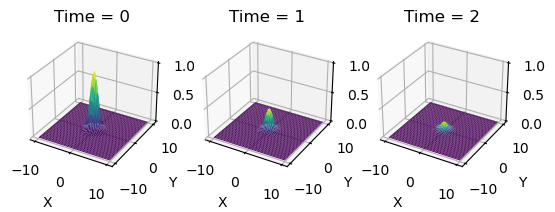

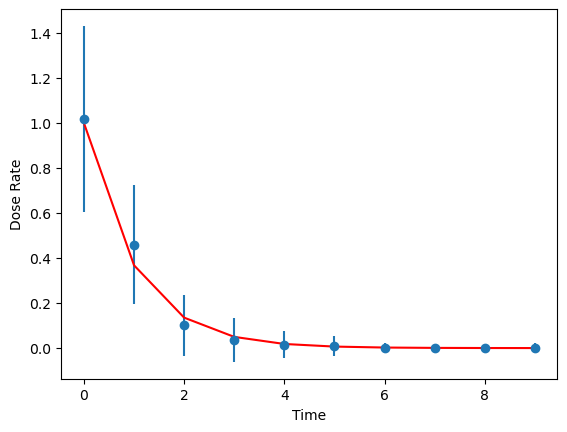

In [165]:
gaussianField = GaussianField(burst_lat=41.2565, burst_long=95.9345, burst_time=0, altitude=0, sigma=1, decayConstant=1)
gaussianField.plotFields()

detector = SimDetector(lat=41.2565, long=95.9445, simRadField=gaussianField, id=1, detMeasurementUncertainty=0.2, expectedDecayRate=1, decayProcessVariance=0.1)
gateways = [Gateway(41.2865, 95.9345), Gateway(41.2565, 95.9545)]

for t in range(10):
  detector.updateSim(t, gateways)
  
detector.plotDoseRate(detector.trueDoseRates)

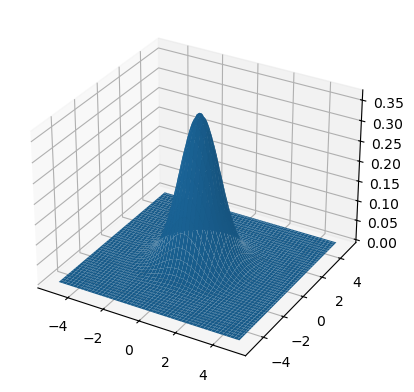

In [1]:
# define a 2d gaussian function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#define a 2d gaussian function that decays exponentially as a function of time
def gaussian_t(x, y, x0, y0, sigma, t, decayConstant=1):
    return np.exp(-((x-x0)**2 + (y-y0)**2)/(2*sigma**2)) * np.exp(-decayConstant*t)

# define a grid between -5 and 5 (representing km)
x = np.linspace(-5, 5, 100)

# create a meshgrid
X, Y = np.meshgrid(x, x)

# create the 2d gaussian
Z = gaussian_t(X, Y, 0, 0, 1, 1)

# plot the 2d gaussian
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()


In [82]:
initial_uncertainty = 0.2 #200 meters
minimum_uncertainty = 0.05 #50 meters
meas_uncertainty = 0.01
n_detectors = 10
n_time_samples = 50

# create a list of n_samples random x and y values within the range -5 to 5
x_test = np.random.uniform(-5, 5, n_detectors)
y_test = np.random.uniform(-5, 5, n_detectors)

# sample the 2d gaussian at these x and y values for each time sample assuming they are sampled as a batch with a time step of 1
z_test = np.array([gaussian_t(x_test, y_test, 0, 0, 1, t, 0.1) for t in range(n_time_samples)])

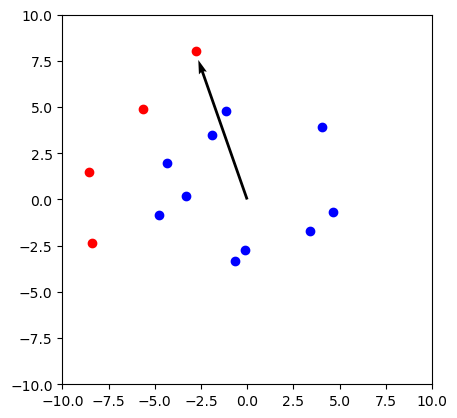

In [83]:
#from the origin, determine a random unit vector to point towards the gun line
u = np.random.rand(2) - 0.5
u = u / np.linalg.norm(u)

gateway_dist = 8

gateways = np.zeros((4, 2))
#the first of 4 gateways lies along the gun line at 8 km from the origin
gateways[0] = gateway_dist * u

#rotate the unit vector by 30 degrees to get the direction of the next gateway
theta = np.pi / 6
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
gateways[1] = np.dot(R, u) * gateway_dist

#rotate the unit vector by 60 degrees to get the direction of the next gateway
theta = np.pi / 3
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
gateways[2] = np.dot(R, u) * gateway_dist

#rotate the unit vector by 90 degrees to get the direction of the next gateway
theta = np.pi / 2
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
gateways[3] = np.dot(R, u) * gateway_dist

#add some noise to the gateway positions
gateways += np.random.normal(0, 0.5, (4, 2))


#plot the gateway positions
plt.scatter(gateways[:,0], gateways[:,1], color='r')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
#make the plot square
plt.gca().set_aspect('equal', adjustable='box')

#plot a vector from the origin to the gun line, make it 8 km long
plt.quiver(0, 0, u[0], u[1], scale=1/gateway_dist, scale_units='xy', angles='xy')

#plot the detector positions
plt.scatter(x_test, y_test, color='b')
plt.show()

In [85]:
#determine the time of flight to each gateway
tof = np.zeros((n_detectors, 4)) #nanoseconds
for i in range(n_detectors):
    for j in range(4):
        tof[i, j] = np.linalg.norm(gateways[j] - np.array([x_test[i], y_test[i]]))

#add some noise to the time of flight
tof += np.random.normal(0, 0.5, (n_detectors, 4))

#perform multilateration to determine the position of the each detector and the uncertainty in the position
#initialize the position and uncertainty of each detector
x_pos = np.zeros(n_detectors)
y_pos = np.zeros(n_detectors)
x_uncertainty = np.zeros(n_detectors)
y_uncertainty = np.zeros(n_detectors)

def calc_dist(delta_t, c=299792458):
    return delta_t * c

def error_function(x, y, tof, gateways):
    return np.sum((np.linalg.norm(gateways - np.array([x, y]), axis=1) - tof)**2)

from scipy.optimize import minimize
def multilaterate(tofs, gateways):
    x0 = np.array([0, 0])
    res = minimize(lambda x: error_function(x[0], x[1], tofs, gateways), x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    # estimate the uncertainty in the position
    uncertainty = np.zeros(2)
    estimated_position = res.x
    for i in range(len(gateways)):
        distance = np.linalg.norm(gateways[i] - estimated_position)
        uncertainty[0] += (estimated_position[0] - gateways[i][0]) ** 2 * res.hess_inv[i, i]
        uncertainty[1] += (estimated_position[1] - gateways[i][1]) ** 2 * res.hess_inv[i, i]
    
    uncertainty = np.sqrt(uncertainty)
    return res.x, uncertainty

for i in range(n_detectors):
    (x_pos[i], y_pos[i]), uncertainty = multilaterate(tof[i], gateways)
    #x_uncertainty[i] = 
    #y_uncertainty[i] = 

#plot the calculated positions of the detectors and the true positions
plt.scatter(x_pos, y_pos, color='r')
plt.scatter(x_test, y_test, color='b')
plt.scatter(gateways[:,0], gateways[:,1], color='g')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
#make the plot square
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Optimization terminated successfully.
         Current function value: 0.585175
         Iterations: 112
         Function evaluations: 217


AttributeError: hess_inv

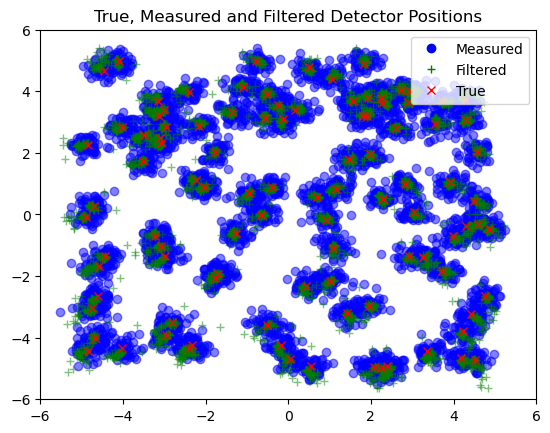

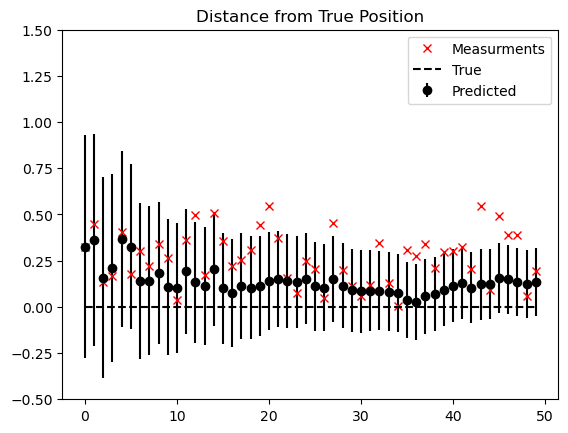

In [27]:
from filterpy.kalman import KalmanFilter
import numpy as np

pos_uncertainty = 0.200 #200 meters
#create position measurements with noise
x_random = x_test.reshape(1, n_detectors) + np.random.normal(0, pos_uncertainty, (n_time_samples, n_detectors))
y_random = y_test.reshape(1, n_detectors) + np.random.normal(0, pos_uncertainty, (n_time_samples, n_detectors))

#initialize the kalman filters
filters = []
for _ in range(n_detectors):
    f = KalmanFilter(dim_x=4, dim_z=2)
    f.x = np.array([x_random[0,0], y_random[0,0], 0, 0])
    f.F = np.array([[1, 0, 1, 0],
                    [0, 1, 0, 1],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])
    f.H = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0]])
    #f.P *= 1000
    # Define the measurement noise covariance
    f.R = np.eye(2) * 0.2 # Measurement noise - this should be near what is expiemntally measured, estimated to be 200 meters

    # Define the process noise covariance
    f.Q = np.eye(4) * 1e-6  # Process noise - static placement, so this is low

    filters.append(f)

#initialize the filtered positions
filtered_positions = []
filter_uncertainty = []

#iterate through the time samples
for t in range(n_time_samples):
    #iterate through the detectors
    for i in range(n_detectors):
        #predict the position
        filters[i].predict()
        #update the position with the measurement
        filters[i].update(np.array([x_random[t, i], y_random[t, i]]))
        #append the filtered position to the list
        filtered_positions.append(filters[i].x)
        #append the calculated uncertainty to the list as a tuple
        filter_uncertainty.append( [np.sqrt(filters[i].P[0, 0]), np.sqrt(filters[i].P[1, 1])] )

filtered_positions = np.array(filtered_positions).reshape(n_time_samples, n_detectors, 4)
filter_uncertainty = np.array(filter_uncertainty).reshape(n_time_samples, n_detectors, 2)
x_uncertainty = filter_uncertainty[:, :, 0]
y_uncertainty = filter_uncertainty[:, :, 1]


# plot the original and filtered x and y positions
plt.plot(x_random, y_random, 'bo', alpha=0.5)
#plot the filtered position as a green +
plt.plot(filtered_positions[:, :, 0], filtered_positions[:, :, 1], 'g+', alpha=0.5)
#plot the true position as a red x
plt.plot(x_test, y_test, 'rx')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.legend(handles=[plt.Line2D([], [], marker='o', color='b', linestyle='None', markerfacecolor='b', label='Measured'),
                    plt.Line2D([], [], marker='+', color='g', linestyle='None', markerfacecolor='g', label='Filtered'),
                    plt.Line2D([], [], marker='x', color='r', linestyle='None', markerfacecolor='r', label='True')])
plt.title('True, Measured and Filtered Detector Positions')
plt.show()

#plot the estimated distance from the true position for all single detectors along with the uncertainty as error bars
for i in range(1):
    distance = np.sqrt((filtered_positions[:, i, 0] - x_test[i])**2 + (filtered_positions[:, i, 1] - y_test[i])**2)
    uncertainty = np.sqrt(x_uncertainty[:,i]**2 + y_uncertainty[:,i]**2)
    plt.errorbar(range(n_time_samples), distance, yerr=uncertainty, fmt='o', color='k')

    #plot the measured distance from the true position for all single detectors
    distance = np.sqrt((x_random[:, i] - x_test[i])**2 + (y_random[:, i] - y_test[i])**2)
    plt.plot(range(n_time_samples), distance, 'x', color='r')

#plot a horizontal dashed line at 0
plt.plot(range(n_time_samples), np.zeros(n_time_samples), 'k--')

#describe the x and circle markers
plt.legend(['Measurments', 'True', 'Predicted'])
plt.title('Distance from True Position')
plt.ylim(-0.5,1.5)
plt.show()





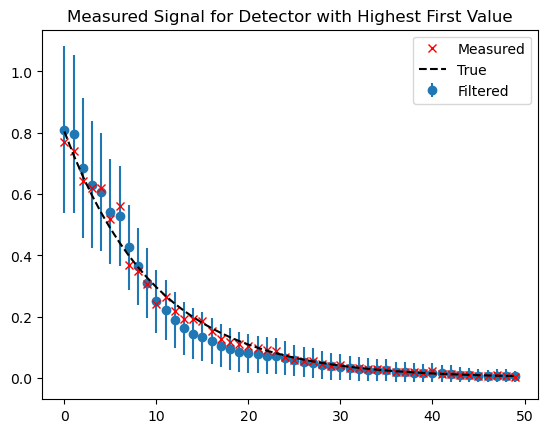

In [4]:
meas_uncertainty = 0.1 # relative uncertainty of 10%
minimum_noise = 0.2
minimum_noise_uncertainty = 0.01
#modify the z's by adding a random number from a normal distribution with a mean of 0 and a standard deviation of 0.1
z_train = z_test + np.random.normal(0, z_test*meas_uncertainty, (n_time_samples, n_detectors)) + minimum_noise*np.random.normal(0, minimum_noise_uncertainty, (n_time_samples, n_detectors))

#ensuer that the measured values are positive
z_train = np.abs(z_train)

#initialize the kalman filters
decay_filters = []

for d in range(n_detectors):
    f = KalmanFilter(dim_x=2, dim_z=1)
    f.x = np.array([z_test[0,d], 1])
    f.F = np.array([[1, 1],
                    [0, 1]])
    f.H = np.array([[1, 0]])
    f.R = np.array([[meas_uncertainty*z_test[0,d]]])
    decayRate = 0.1
    process_noise_variance = 0.01
    f.Q = np.array([[0, 0],
                    [0, process_noise_variance * decayRate**2]])
    decay_filters.append(f)

#initialize the filtered data
filtered_data = np.zeros((n_time_samples, n_detectors, 2))

for t in range(n_time_samples):
    for d in range(n_detectors):
        decay_filters[d].R = np.array([[meas_uncertainty * z_train[t, d]]])
        decay_filters[d].predict()
        decay_filters[d].update(z_train[t, d])
        filtered_data[t, d, 0] = decay_filters[d].x[0]
        filtered_data[t, d, 1] = np.sqrt(decay_filters[d].P[0, 0])

#plot z_train for the detector with the highest first value
idx = np.argmax(z_train[0, :])
plt.errorbar(range(n_time_samples), filtered_data[:, idx, 0], yerr=filtered_data[:, idx, 1], fmt='o', label='Filtered', zorder=1)
plt.plot(range(n_time_samples), z_train[:, idx], 'x', c='r', label='Measured', zorder=2)
plt.plot(range(n_time_samples), z_test[:, idx], 'k--', label='True', zorder=3)
plt.title('Measured Signal for Detector with Highest First Value')
plt.legend()
plt.show()

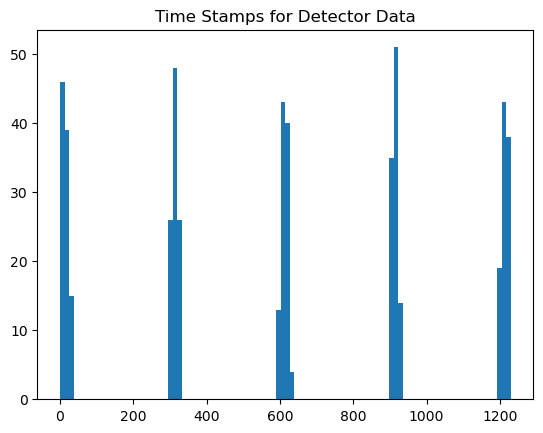

In [26]:
#restructure the data to be a list of tuples ordered by time of information arrival. The detectors transmit thier data, not all at once, or in the same order, but typically every 5 minutes.
# the tuple format should take the form of (time, det_reading, det_unc, x_cal, y_cal, x_unc, y_unc, baro)
#where time is the time the data was received, det_reading is the reading from the detector, det_unc is the uncertainty of the reading, x_cal, y_cal are the calculated
# x and y positions of the detector, and baro is the barometric pressure reading. The barometric pressure reading is assumed to be constant for this example.

#for each time step (roughly 300 seconds) create n_detectors timestamps within a 30 second window
import time


time_stamps = np.random.uniform(0, 30, n_detectors*n_time_samples)
time_stamps = time_stamps.reshape(n_time_samples, n_detectors)
gross_time_steps = np.arange(0, n_time_samples*300, 300).reshape(n_time_samples, 1)
time_stamps = time_stamps + gross_time_steps

data = []
for t in range(n_time_samples):
    for d in range(n_detectors):
        data.append((time_stamps[t, d], z_train[t, d], filtered_data[t, d, 1], filtered_positions[t, d, 0], filtered_positions[t, d, 1], x_uncertainty[t, d], y_uncertainty[t, d], 1013.25))